<a href="https://colab.research.google.com/github/SudeepSarkar/sarkar-computer-vision-lectures/blob/main/CV_Module_7_1_7_2_2D_to_3D_camera_calibration_and_pose_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Camera and Pose Estimation: Finding the transformation between 2D and 3D

In this notebook, you will learn about

* different types of 3D geometry recovery problems: pose estimation, camera calibration, stereo, True 3D, and motion sequence.

* examples of different types of geometry estimation problems in computer vision.

* different types of rotation matrix representation: Euler angle-based, axis/angle (exponential twist), and quaternions.

* mathematical representations of the different components of the pin-hole camera projection model.

* formulation of the camera calibration process in terms of intrinsic and extrinsic parameters.

* direct linear transformation (DLT) based rough estimation of the camera extrinsic parameters.

* how to refine the DLT estimates by performing a non-linear optimization over all the parameters using PyTorch functions

* the use of a PyTorch optimization method to solve the estimation problem.

**New concepts learned:** pose estimation, camera calibration, stereo, disparity, true 3D, motion sequence, Euler angles, exponential twists, quaternions, pin-hole camera model, intrinsic and extrinsic camera model, direct linear transformation (DLT), RQ and QR decomposition.

# Examples of 3D geometry recovery

We will study the recovery of 3D structure from 2D image(s) over the next couple of weeks. The following situations are different types of estimation scenarios.



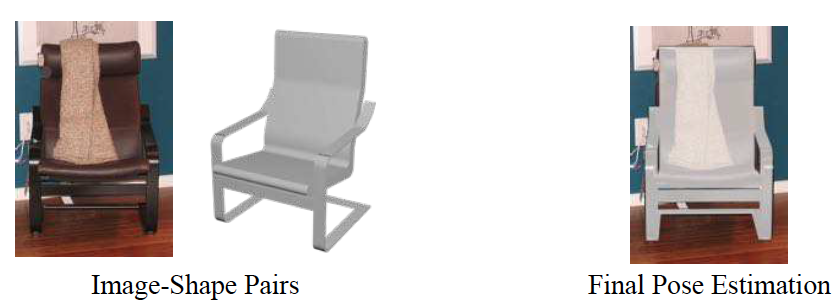

## Pose estimation (fixed camera, static object)

**The above picture is taken from the paper "[Pix3D: Dataset and Methods for Single-Image 3D Shape Modeling](https://openaccess.thecvf.com/content_cvpr_2018/papers/Sun_Pix3D_Dataset_and_CVPR_2018_paper.pdf)".**

**The pose estimation problem is aligning the 3D model to the image.**

**The 3D model is specified with respect to a coordinate system attached to the model.**

**The 2D image is with respect to the camera coordinates.**

**A rotation and translation specify the alignment problem.**

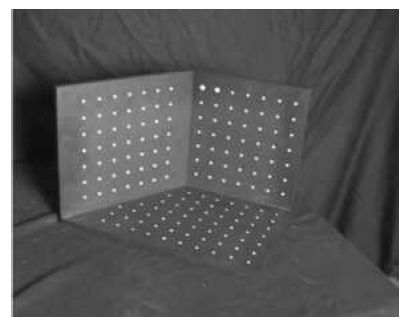

## Camera calibration (fixed camera, static scene)

**For camera calibration, we take images of a 3D calibration object whose dimensions we know and then estimate the intrinsic and extrinsic parameters of the camera**

**The camera calibration problem is equivalent to the pose estimation problem.**


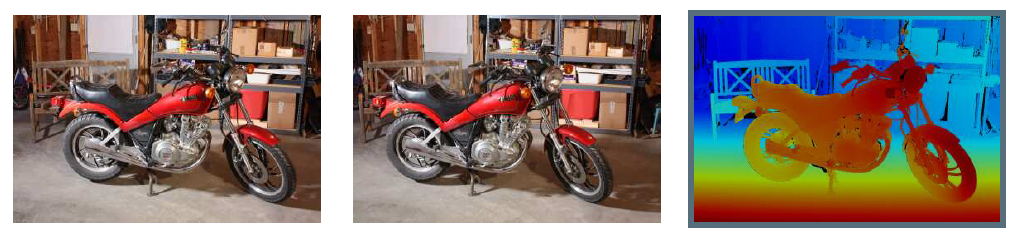

## Stereo (fixed cameras, static or dynamic objects)

**What is the difference between the two images above? How many cameras were used? Can you estimate the 3D dimensions of the motorbike from the 2D images?**

**We can estimate only the depth from the camera, i.e., partial 3D information. This is referred to as 2.5 D, range, or depth image.**

## True 3D (vs 2.5D or partial 3D) from multi-camera data (fixed cameras, static or dynamic scenes)

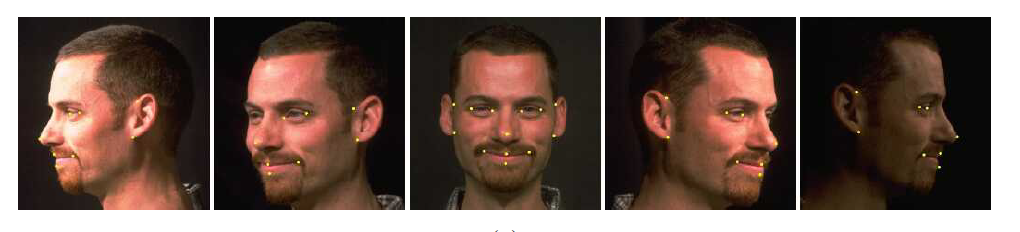

**Can you recover the 3D dimensions of salient facial images from these images? How many cameras were used?**

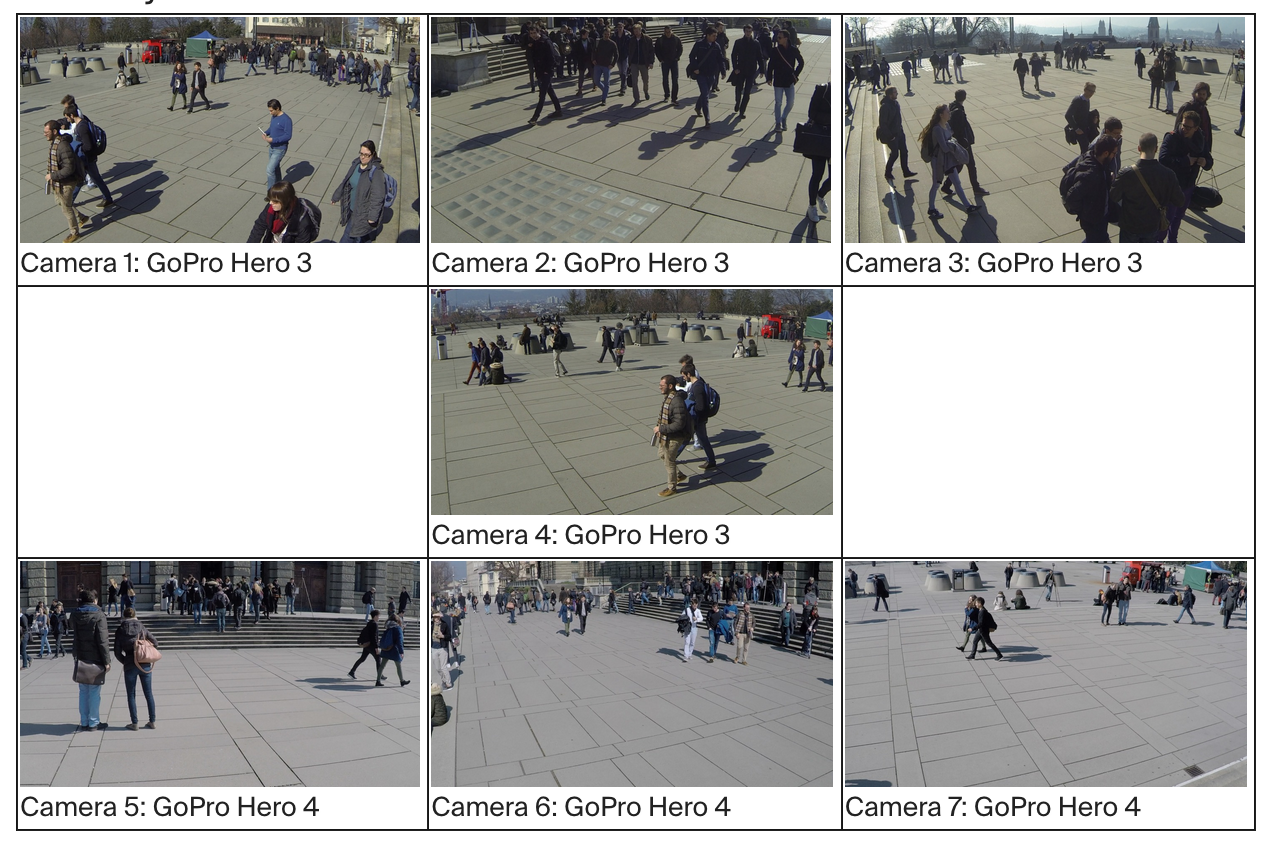

**WILDTRACK dataset multiple cameras of a common 3D scene, known camera geometry**

"[WILDTRACK: A Multi-Camera HD Dataset for Dense Unscpted Pedestrian Detection](https://openaccess.thecvf.com/content_cvpr_2018/html/Chavdarova_WILDTRACK_A_Multi-Camera_CVPR_2018_paper.html)," Tatjana Chavdarova, Pierre Baqué, Stéphane Bouquet, Andrii Maksai, Cijo Jose, Timur Bagautdinov, Louis Lettry, Pascal Fua, Luc Van Gool, François Fleuret; Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 2018, pp. 5030-5039 

The full dataset is available at https://www.epfl.ch/labs/cvlab/data/data-wildtrack/


In [1]:
from google.colab import drive
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/Colab Notebooks/CAP 6415 Computer Vision Online/data/'


KeyboardInterrupt: ignored

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from skimage import io

!pip install opencv-contrib-python==4.4.0.46
import cv2
print (cv2 .__version__)

np.set_printoptions(precision=4, suppress=True)
torch.set_printoptions(precision=4, sci_mode=False)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.7/55.7 MB 7.9 MB/s eta 0:00:00
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.7.0.72
    Uninstalling opencv-contrib-python-4.7.0.72:
      Successfully uninstalled opencv-contrib-python-4.7.0.72
4.4.0


## Motion sequence (moving camera, scene mostly static)

**given two motion frames estimate the 3D scene, i.e., distance to points in the scene**

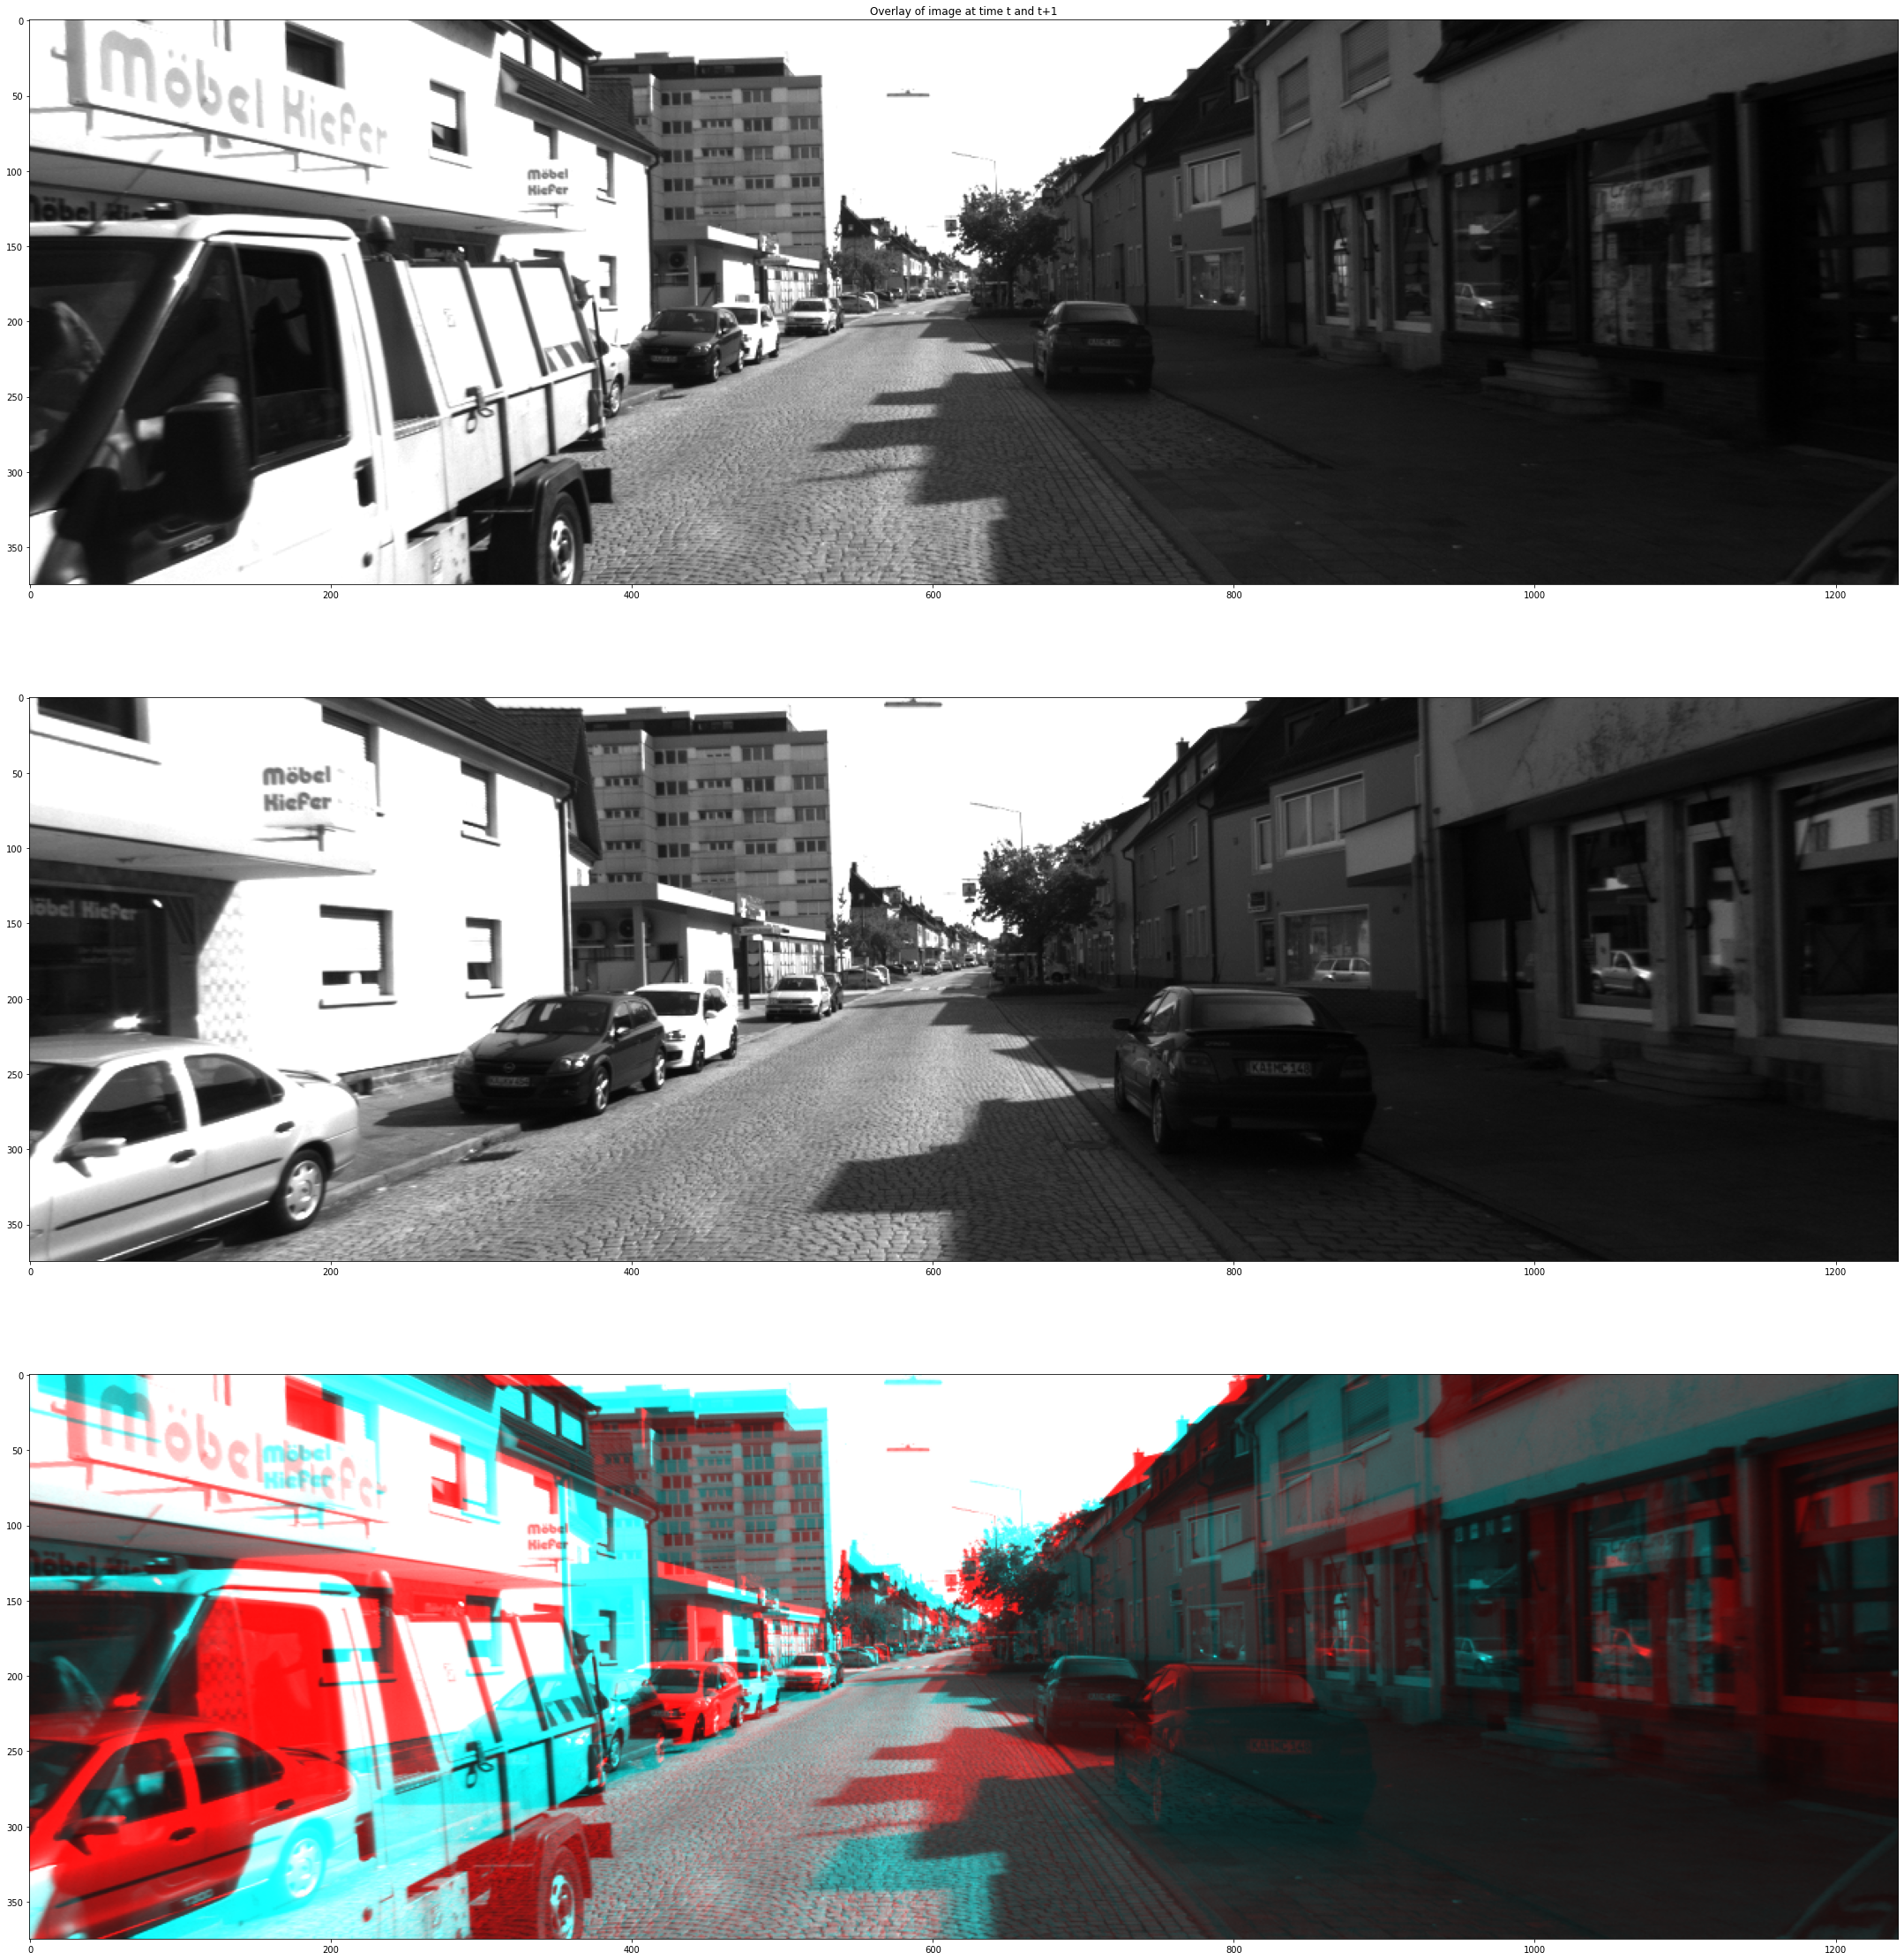

In [ ]:
# You can change the image files to select different image pairs
image_1 = io.imread(data_dir+'2011_09_26_drive_0048_sync/image_00/data/0000000005.png')
image_2 = io.imread(data_dir+'2011_09_26_drive_0048_sync/image_00/data/0000000015.png')


image_1 = cv2.cvtColor(image_1, cv2.COLOR_RGB2BGR) # change from scikit image to cv2 format
image_2 = cv2.cvtColor(image_2, cv2.COLOR_RGB2BGR)
image_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2GRAY) # change from color to gray
image_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2GRAY)

seq_im_2_into_1 = np.zeros((image_1.shape[0], image_1.shape[1], 3))
seq_im_2_into_1[..., 0] = image_2/255
seq_im_2_into_1[..., 1] = image_1/255
seq_im_2_into_1[..., 2] = image_1/255

#----------------------------------Display-------------------------------------------------------
# draw matches
fig, ((ax1), (ax2), (ax3)) = plt.subplots(3, 1)
fig.set_size_inches(80, 40)

ax1.imshow(image_1, 'gray')
ax1.set_title('Image at time t')
ax2.imshow(image_2, 'gray')
ax1.set_title('Image at time t+1')
ax3.imshow(seq_im_2_into_1, 'gray')
ax1.set_title('Overlay of image at time t and t+1');



# Assignment -- frames from a motion sequence vs. stereo

* The above code displays the motion frames from one cameras for two instants. Change the code to display stereo frames, i.e., image frames from two cameras (say camera-00 and camera-03) for the same instants.

* Compare the disparity pattern observed between the two cases, i.e., the stereo and the motion frames, and explain the similarities and differences.

# Types of geometry recovery problems

* The table below shows three types of geometry recovery problems we can encounter in computer vision. Each row in the table represents a different situation, and the columns present the known (colored green) and unknown (colored red) components. 
    * The input data, i.e., 2D points on the image, is shown in the third column. These points could be from one image or multiple images, and the multiple images could be from different static cameras or video frames from a motion sequence. The motion sequence could be due to the camera's motion or motion of the object, or both.
    * The second column is the camera geometry (or pose) concerning the world coordinates. When dealing with multiple cameras, we might specify this camera geometry with respect to the first camera. When dealing with a motion sequence, we might define this camera geometry with respect to the camera position at the last instant.
    * The scene geometry (the first column) represents the 3D coordinates of points in the world with respect to the world coordinate system.



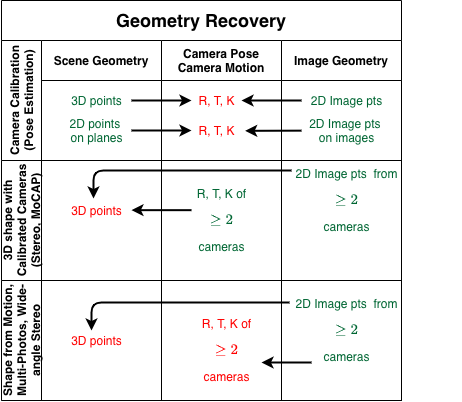

# 3D rotations

See Section 2.1.4 of the textbook. Here are three different ways to represent a 3D rotation matrix. Remember that 3D rotation has 3 degrees of freedom, so if we use more than 3 numbers to represent rotation, these numbers are not all independent.

* **[Euler angles](https://en.wikipedia.org/wiki/Euler_angles)**: This is a representation you are probably familiar. A rotation matrix can be formed as the product of three rotations around three cardinal axes, e.g., $x$, $y$, and $z$, or $x$, $y$, and $x$. This representation has serious issues:

    \begin{equation}
    \mathbf{R} = \mathbf{R}_z \mathbf{R}_y \mathbf{R}_x
    \end{equation}

    * The result depends on the order in which the transforms are applied. 

    * The space of the angles is NOT uniform, and we cannot move smoothly in the space of angles. Look up **Gimble lock**.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation 

r = Rotation.from_euler('zyx', [10, 0, 30], degrees=True) # r is a Rotation object in scipy 
print('R_zyx =\n', r.as_matrix ())

r = Rotation.from_euler('xyz', [30, 0, 10], degrees=True) # r is a Rotation object in scipy 
print('\nR_xyz =\n', r.as_matrix ())

R_zyx =
 [[ 0.9848 -0.1736  0.    ]
 [ 0.1504  0.8529 -0.5   ]
 [ 0.0868  0.4924  0.866 ]]

R_xyz =
 [[ 0.9848 -0.1504  0.0868]
 [ 0.1736  0.8529 -0.4924]
 [ 0.      0.5     0.866 ]]


* **[Axis/angle (exponential twist)](https://en.wikipedia.org/wiki/Axis%E2%80%93angle_representation)**: A rotation can be represented by a rotation axis, $\hat{\mathbf{n}}$ and an angle, $\theta$, or equivalently by a 3D vector $\omega = \theta \hat{\mathbf{n}}$. **This is a minimal representation for a 3D rotation.**  BUT,

    * The representation is not unique: $\theta \hat{\mathbf{n}}$, $ (\theta + 2 \pi) \hat{\mathbf{n}}$, and $(-\theta)(-\hat{\mathbf{n}})$, all represent the same rotation.

    * The rotation matrix $R(\hat{\mathbf{n}}, \theta)$ representing a finite rotation can be shown to be equal to $\exp (\theta[\hat{\mathbf{n}}]_{\times})$, where

    \begin{eqnarray}
    [\hat{\mathbf{n}}]_{\times} & = &
    \begin{bmatrix} 
    0 & -\hat{n}_z & \hat{n}_y \\
    \hat{n}_z & 0 & -\hat{n}_x \\
    -\hat{n}_y & \hat{n}_x & 0 
    \end{bmatrix}
    \end{eqnarray}

    * (Question) What is the relationship of this 3 by 3 matrix to cross products? Find out! It will help you compute cross products with just one matrix multiply. 

    * For small rotations, this rotation matrix can be shown to simply.

    \begin{eqnarray}
    \mathbf{R}(\omega) & \approx & 
    \begin{bmatrix} 
    1 & -\omega_z & \omega_y \\
    \omega_z & 1 & -\omega_x \\
    -\omega_y & \omega_x & 1 
    \end{bmatrix} \\
    & = & \mathbf{I} +
    \begin{bmatrix} 
    0 & -\omega_z & \omega_y \\
    \omega_z & 0 & -\omega_x \\
    -\omega_y & \omega_x & 0
    \end{bmatrix} \\
    \end{eqnarray}

* **[Unit quaternions](https://en.wikipedia.org/wiki/Quaternions_and_spatial_rotation)** is a generalization of angle/axis notation. 

    * A unit quaternion is a unit length 4-vector whose components can be written as 
    
    \begin{equation} \mathbf{q} = \begin{bmatrix} q_x \\ q_y \\ q_z\\ q_w \end{bmatrix}
    \end{equation}

    whose magnitude is 1. This 4-d representation is also sometimes represented as a combination of a 3-d vector and a scalar, $(\mathbf{v}, w)$. 

    * Quaternions can be derived from the axis/angle representation through the formula: 
    \begin{equation}
     \mathbf{q} = (\mathbf{v}, w) = \left [ \sin(\frac{\theta}{2}) \hat{\mathbf{n}}, \cos(\frac{\theta}{2}) \right ]
     \end{equation}

    * These quaternions live on the unit sphere. Antipodal (opposite sign) quaternions, $\mathbf{q}$ and $-\mathbf{q}$, represent the same rotation. Other than this issue, the representation is unique and has several important mathematical properties.

    * The representation is continuous, i.e., as rotation matrices vary continuously.
    * Multiplication and division of two quaternions can be performed using algebraic forms. See Eq. 2.42 and 2.43 in the textbook.

    * And more importantly, it is easy to interpolate between two rotations. (Eq. 2.45)


# Camera Calibration (Pose Estimation)

* Section 6.2 of the textbook also Section 2.1

* Camera calibration involves the estimation of the *intrinsic* and *extrinsic* parameters. For most applications, the intrinsic parameters, once estimated, can be reused, except for cameras with zoom whose focal length changes for any change in zoom. However, we will need to re-estimate the extrinsic parameters of each camera placement. 

* Extrinsic parameter estimation, which involves the computation of the rotation and translation from world coordinates to camera coordinates, is similar to another problem in computer vision, namely, **pose estimation**. The pose estimation problem involves assessing rotation and translation to align a 3D model of an object to the image.The underlying technical problem is the same in both cases.

**External References:**

1. R. Tsai, "[A versatile camera calibration technique for high-accuracy 3D machine vision metrology using off-the-shelf TV cameras and lenses](https://ieeexplore.ieee.org/abstract/document/1087109?casa_token=4tTww9X2o_0AAAAA:GL38gGlKjDMukBkdwb7dsx8CHI2zo8yZWBikfvw6M1CvA1xOzit71iGdeqm-GE6C2AZFggWr)," in IEEE Journal on Robotics and Automation, vol. 3, no. 4, pp. 323-344, August 1987, doi: 10.1109/JRA.1987.1087109.

2. B. K. P Horn, "[Tsai’s camera calibration method revisited](http://people.csail.mit.edu/bkph/articles/Tsai_Revisited.pdf)."

3. Aaron T. Becker's Robot Swarm Lab (2021). Calibrate camera with one Photo (Linear Method), [MATLAB Central File Exchange](https://www.mathworks.com/matlabcentral/fileexchange/73079-calibrate-camera-with-one-photo-linear-method). Retrieved February 20, 2021. 



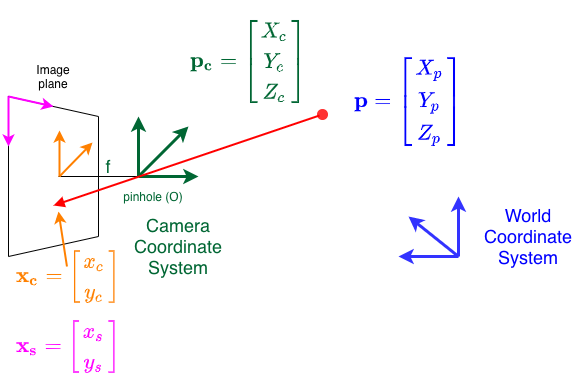

# Perspective Camera Model (with lens distortion)

The camera transformation can be broken up into four steps that take the 3D coordinates of a point, with respect to the world coordinate system, to the 2D pixel location in an image.

1. **World coordinates to Camera coordinates 3D transformation:** This transformation of the 3D point (in homogeneous coordinates) is a product of a 3 by 4 *extrinsic parameter matrix* composed of a 3 by 3 rotation matrix, $\mathbf{R}$, and a 3 by 1 translation vector $\mathbf{t}$.

\begin{eqnarray} 
    \begin{bmatrix} X_c \\ Y_c \\ Z_c \end{bmatrix} 
    & = &
    \begin{bmatrix}
    r_{00} & r_{01} & r_{02} & t_x \\ 
    r_{10} & r_{11} & r_{12} & t_y \\
    r_{20} & r_{21} & r_{22} & t_z 
    \end{bmatrix}
    \begin{bmatrix}
    X_p \\ Y_p \\ Z_p \\ 1
    \end{bmatrix}  
\end{eqnarray}

2. **Perspective projection of 3D coordinates into 2D coordinates** projects the 3D location to the 2D image plane. This introduces non-linearity into the transformation chain through the division operation. The following equations give it

\begin{equation} 
\begin{bmatrix} {x}_c \\  {y}_c \end{bmatrix} =
\begin{bmatrix} 
\frac{X_c}{Z_c} \\
\frac{Y_c}{Z_c}
\end{bmatrix}
\end{equation}

3. **Lens distortion** models the distortion introduced by the lens. See Section 2.1.5 and Fig. 2.13 on page 65 of the textbook (second edition) for examples of lens distortions. Mathematically, the simplest radial distortion models can be expressed using low-order polynomials,
    
\begin{equation} 
\begin{bmatrix} \hat{x}_c \\  \hat{y}_c \end{bmatrix} =
\begin{bmatrix} 
x_c (1 + \kappa_1 r^2 + \kappa_2 r^4) \\
y_c (1 + \kappa_1 r^2 + \kappa_2 r^4)
\end{bmatrix}
\end{equation}

4. **Intrinsic Camera Parameter Transformation** scales the 2D coordinates by focal length ($f$) and shifts the center $(c_x, c_y)$ to the corner of the image so that we can reference the image location in terms of the pixel locations in an image. In general, a pixel sensor might not be square, and we allow for a rectangular-shaped pixel using an aspect ratio parameter, $a$.

\begin{equation} 
\begin{bmatrix} {x}_s \\  {y}_s \end{bmatrix} =
\begin{bmatrix} 
f \hat{x}_c + c_x \\
af \hat{y}_c + c_y
\end{bmatrix}
\end{equation}

> This equation can be compactly represented using a 3 by 3 intrinsic parameter matrix $\mathbf{K}$. 

\begin{eqnarray} 
\begin{bmatrix} {x}_s \\  {y}_s  \\ 1 \end{bmatrix} 
& =  &
\begin{bmatrix} 
f & 0 & c_x \\ 
0 & af & c_y \\ 
0 & 0 & 1
\end{bmatrix}
\begin{bmatrix} 
\hat{x}_c  \\
\hat{y}_c \\ 
1
\end{bmatrix} \\ 
& = &
\mathbf{K}^{3x3}  \begin{bmatrix} 
\hat{x}_c  \\
\hat{y}_c \\ 
1
\end{bmatrix}
\end{eqnarray}


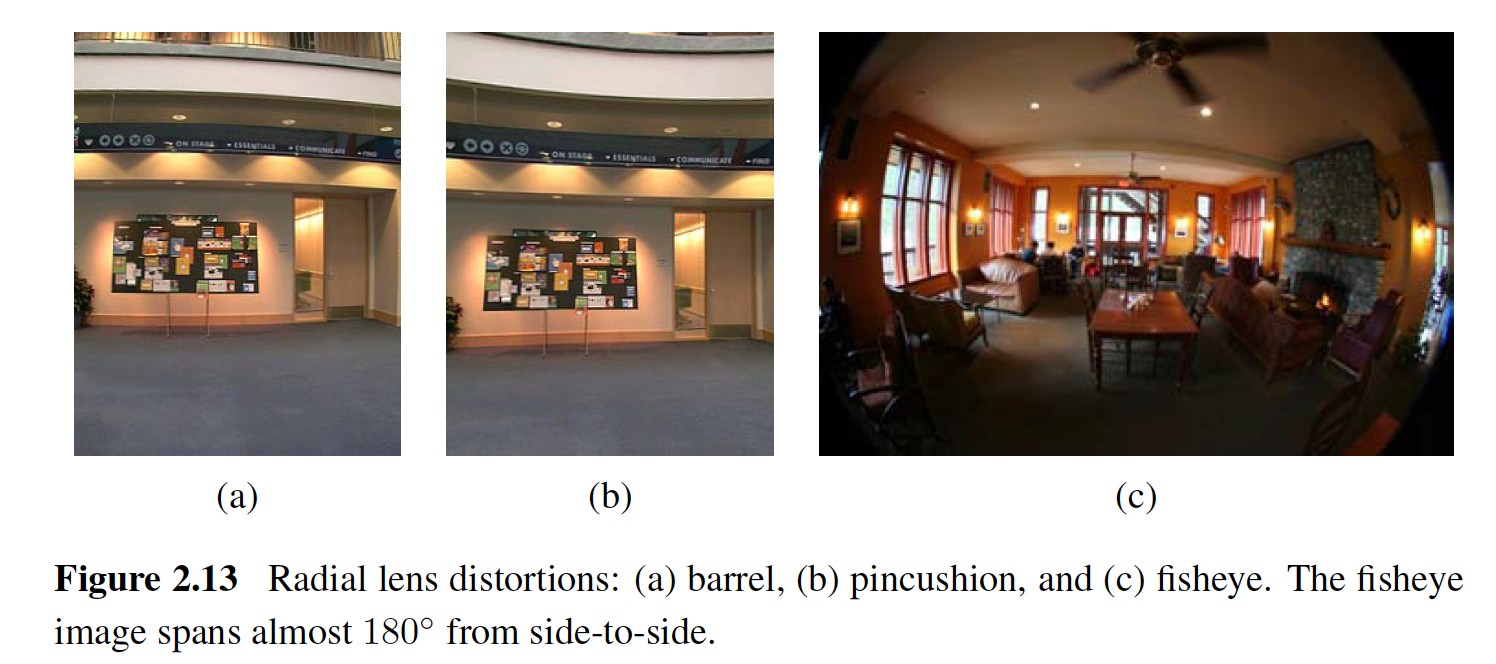


### Code: Create test data of 3D point and their 2D projections (`forward_projective (param, X_w)`)

Dimensions of X_world_gt: torch.Size([4, 8, 1])
Rotation matrix=
 [[ 0.9848  0.      0.1736]
 [ 0.0868  0.866  -0.4924]
 [-0.1504  0.5     0.8529]] 
Quaterion =
 [0.2578 0.0842 0.0226 0.9623] 
Euler angles (zyx)=
 [ 0. 10. 30.]
T =
 [-2 -1 10]

Extrinsic parameter matrix, RT_gt =
 [[ 0.9848  0.      0.1736 -2.    ]
 [ 0.0868  0.866  -0.4924 -1.    ]
 [-0.1504  0.5     0.8529 10.    ]]
Intrinsic parameter matrix, K_gt =
 [[300.   0. 200.]
 [  0. 300. 200.]
 [  0.   0.   1.]]


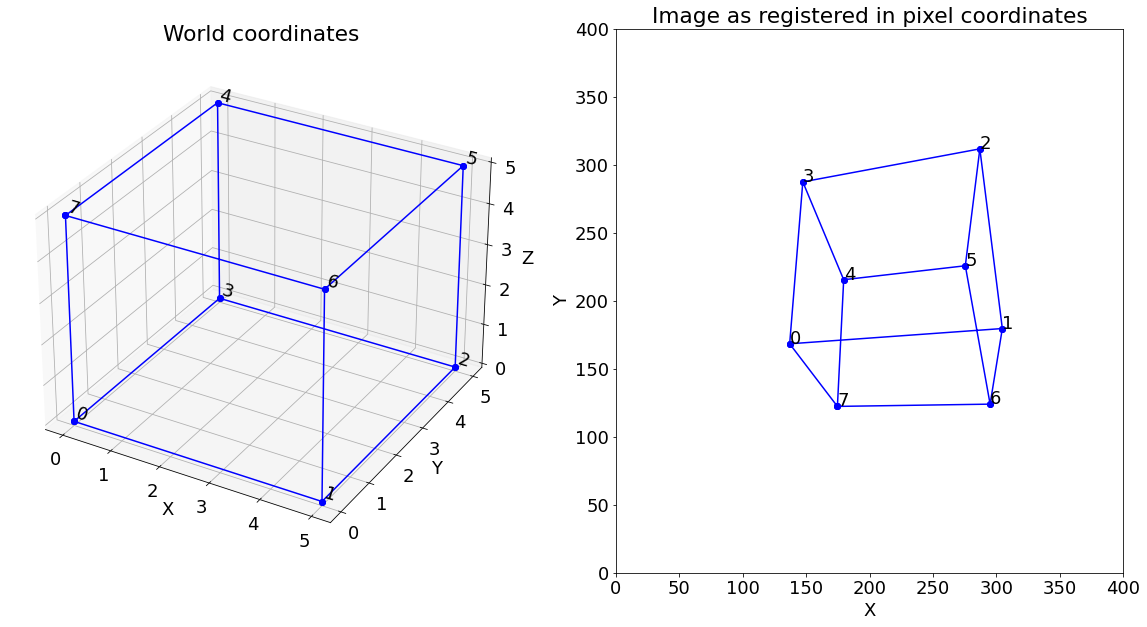

In [ ]:
''' Code to generate the 2D image locations given the 3D world coordinates, illustrated using points on a cube, '''
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation 

#------------------FORWARD CAMERA MODEL (3D to 2D) -----------------------------------------
def forward_projective (param, X_w) :
# Maps 3D points (X_w) into image points (x_s, y_s) based on the parameters param
# Later on we will use this function to estimate paramters using torch autograd 
# so it is defined using pytorch variables and functions
#
# We have 14 input parameters that are pass in the vector param
    '''14 parameters: (f/s_x, gamma, c_x, f/s_y, c_y,) (q_x, q_y, q_z, q_w) (t_x, t_y, t_z,) (kappa1, kappa2)
                        0,    1  ,   2 ,     3,   4 ,   5 ,  6  , 7,    8,   9,   10   11,     12,     13'''
    #---------------------------------------------------------------------------
 
    ''' form the rotation matrix from the quaterion parameters'''
    # normalize the quaternion vector first
    x = param[5]; y = param[6]; z = param[7]; w = param[8]
    quaternion_mag = torch.sqrt(torch.pow(x, 2) + torch.pow(y, 2) + torch.pow(z, 2) + torch.pow(w, 2))
    x = torch.div(x, quaternion_mag) 
    y = torch.div(y, quaternion_mag)
    z = torch.div(z, quaternion_mag) 
    w = torch.div(w, quaternion_mag)

    # form the rotation matrix from quaternion values
    R_00 =  1 - 2*(y*y + z*z);    R_01 =  2*(x*y - z*w);         R_02 =  2*(x*z + y*w)
    R_10 =  2*(x*y + z*w);        R_11 =  1 - 2*(x*x + z*z);     R_12 =  2*(y*z - x*w) 
    R_20 = 2*(x*z - y*w);          R_21 =  2*(y*z + x*w);        R_22 =  1 - 2*(x*x + y*y)
    #print('R=\n', R_00, R_01, R_02, '\n', R_10, R_11, R_12, '\n', R_20, R_21, R_22)

    ''' perform the 3D rotation and translation '''
    X_c = R_00*X_w[0,:] + R_01*X_w[1,:] + R_02*X_w[2,:] + param[9]
    Y_c = R_10*X_w[0,:] + R_11*X_w[1,:] + R_12*X_w[2,:] + param[10]
    Z_c = R_20*X_w[0,:] + R_21*X_w[1,:] + R_22*X_w[2,:] + param[11]
    #print(X_w.shape, X_c.shape, Y_c.shape, Z_c.shape)

    '''Perspective projection'''
    x_c = torch.div(X_c, Z_c)
    y_c = torch.div(Y_c, Z_c)
    #print('x_c', x_c)

    ''' Lens distortion'''
    r_sq = torch.pow(x_c, 2) + torch.pow(y_c, 2)
    distortion_factor = 1 + param[12]*r_sq + param[13]*torch.pow(r_sq, 2)
    x_hat = x_c * distortion_factor
    y_hat = y_c * distortion_factor

    ''' multiply by intrinsic transform'''
    x_s = param[0] * x_hat + param[1] * y_hat + param[2]; 
    y_s = param[3] * y_hat + param[4]
    
    return (x_s, y_s)

#-------------------------Some support functions------------------------------------
def plot_cube (axis, p_t, c='b', marker='o') :
# Given 8 vertices (p_t is 3 by 8), plot the 3D cube edges and vertices
    axis.plot3D(p_t[0, :], p_t[1, :], p_t[2, :], c=c, marker=marker)
    axis.plot3D([p_t[0,0], p_t[0,7]], [p_t[1,0], p_t[1,7]], [p_t[2,0], p_t[2,7]], c=c, marker=marker)
    axis.plot3D([p_t[0,2], p_t[0,5]], [p_t[1,2], p_t[1,5]], [p_t[2,2], p_t[2,5]], c=c, marker=marker)
    axis.plot3D([p_t[0,1], p_t[0,6]], [p_t[1,1], p_t[1,6]], [p_t[2,1], p_t[2,6]], c=c, marker=marker)
    axis.plot3D([p_t[0,0], p_t[0,3]], [p_t[1,0], p_t[1,3]], [p_t[2,0], p_t[2,3]], c=c, marker=marker)
    axis.plot3D([p_t[0,4], p_t[0,7]], [p_t[1,4], p_t[1,7]], [p_t[2,4], p_t[2,7]], c=c, marker=marker)
    axis.set_xlabel('X')
    axis.set_ylabel('Y')
    axis.set_zlabel('Z')
    for i in range(8):
        axis.text(p_t[0,i], p_t[1,i], p_t[2,i], '{}'.format(i), 'x')

# ---------Utility function to draw the sides of a cube in 2 dimensions (image)-------------

def plot_cube_2D (axis, x, y, c='b', marker='o') :
# Given the x and y coordinates of the 8 vertices , plot the 3D cube edges and vertices
    axis.plot(x, y, c=c, marker=marker)
    axis.plot([x[0], x[7]], [y[0], y[7]], c=c, marker=marker)
    axis.plot([x[2], x[5]], [y[2], y[5]], c=c, marker=marker)
    axis.plot([x[1], x[6]], [y[1], y[6]], c=c, marker=marker)
    axis.plot([x[0], x[3]], [y[0], y[3]], c=c, marker=marker)
    axis.plot([x[4], x[7]], [y[4], y[7]], c=c, marker=marker)

    axis.set_xlabel('X')
    axis.set_ylabel('Y')
    axis.set_xlim(0, 400)
    axis.set_ylim(0, 400)

    for i in range(8):
        axis.text(x[i], y[i], '{}'.format(i))

#---------------------------------------------------------------
# Specification of the 8 vertices of a 5 by 5 by 5 sized cube with one of the vertices at origin of the world coordinates (homogenous)
N = 8
X_world_gt = torch.tensor([[0, 0, 0, 1], [5, 0, 0, 1], [5, 5, 0, 1], [0, 5, 0, 1], [0, 5, 5, 1], [5, 5, 5, 1], [5, 0, 5, 1], [0, 0, 5, 1]], dtype=float)
X_world_gt = X_world_gt.unsqueeze(2) # the dimension for p_tilde will change from (N by 4) to (N by 4 by 1)
X_world_gt = X_world_gt.transpose(0,1)
print('Dimensions of X_world_gt:', X_world_gt.shape)

#---------------------------------------------------------------
# Setup the camera rotation and translation with respect to the world coordinates

# using scipy rotation construct to simplify the translations between different representations
# r = Rotation.from_matrix(R)  
r = Rotation.from_euler('zyx', [0, 10, 30], degrees=True) # r is a Rotation object in scipy 
q = r.as_quat() #transform into quaterion parameters
t_gt = np.array([-2, -1, 10]) #np.array([-2, -1, 1000]) 
f = 300.0 #30000 # 
c_x = 200
c_y = 200
a = 1.0
gamma = 0.0
kappa1 = 1
kappa2 = 0

parameters = torch.tensor([f, gamma, c_x, a*f, c_y, q[0], q[1], q[2], q[3], t_gt[0], t_gt[1], t_gt[2], kappa1, kappa2])

x_image_gt, y_image_gt = forward_projective (parameters, X_world_gt)


#---------------------------------------------------------------

print('Rotation matrix=\n', r.as_matrix(), '\nQuaterion =\n', q, '\nEuler angles (zyx)=\n', r.as_euler('zyx', degrees=True))
print('T =\n', t_gt)
RT_gt = np.zeros((3,4))
R_gt = r.as_matrix()
RT_gt[0:3,0:3] = R_gt
RT_gt[0:3,3] = t_gt 
print('\nExtrinsic parameter matrix, RT_gt =\n', RT_gt)

K_gt = np.zeros((3, 3))
K_gt[0,0] = f; K_gt[0,1] = gamma; K_gt[0,2] = c_x
K_gt[1,1] = a*f; K_gt[1,2] = c_y;   K_gt[2,2] = 1
print('Intrinsic parameter matrix, K_gt =\n', K_gt)

P_gt = K_gt @ RT_gt

# plot the cube in the the world coordinates
fig = plt.figure(figsize=(20,10))
plt.rc('font', size=18)  

ax = fig.add_subplot(1,2,1, projection='3d')
plot_cube (ax, X_world_gt[0:3,:,0].numpy())
ax.set_title('World coordinates')

ax = fig.add_subplot(1,2,2)
plot_cube_2D (ax, x_image_gt.numpy(), y_image_gt.numpy())

ax.set_title('Image as registered in pixel coordinates');


# Assignment-- viewing a cube

Use a physical cube (a dice?) to aid you in visualizing.

1. Change the rotation matrix to an identity matrix, i.e., no rotation, and see how the image looks. Which face of the cube is captured in the image?

2. Use just a rotation about the z-axis of 30-degree and show the image.

3. Use just a rotation about the y-axis of 30-degree and show the image.

4. Use just a rotation about the x-axis of 30-degree and show the image.

5. The case we have considered so far is that of a cube near the camera. Move the cube to a distance by manipulating the z-component of the translation (say 1000 units away) and increase the focal length so that the image of the cube is of similar size as the earlier case. Repeat the above 4 rotations and show the images.

Compare and contrast the 8 images created and explain your observations.

# Simplified Perspective Camera Model (without lens distortion)

* Without lens distortion, the camera transformation will have **three** different steps that take the 3D coordinates of a point, with respect to the world coordinate system, to the 2D pixel location in an image.

    1. **World coordinates to Camera coordinates 3D transformation:** This transformation of the 3D point (in homogeneous coordinates) is a product of a 3 by 4 *extrinsic parameter matrix* composed of a 3 by 3 rotation matrix, $\mathbf{R}$, and a 3 by 1 translation vector $\mathbf{t}$.

    \begin{eqnarray} 
        \begin{bmatrix} X_c \\ Y_c \\ Z_c \end{bmatrix} 
        & = &
        \begin{bmatrix}
        r_{00} & r_{01} & r_{02} & t_x \\ 
        r_{10} & r_{11} & r_{12} & t_y \\
        r_{20} & r_{21} & r_{22} & t_z 
        \end{bmatrix}
        \begin{bmatrix}
        X_p \\ Y_p \\ Z_p \\ 1
        \end{bmatrix}  
    \end{eqnarray}

    2. **Perspective projection of 3D coordinates into 2D coordinates** projects the 3D location to the 2D image plane. This a introduces non-linearity into the transformation chain through the division operation. It is given by the following equations

    \begin{equation} 
    \begin{bmatrix} {x}_c \\  {y}_c \end{bmatrix} =
    \begin{bmatrix} 
    \frac{X_c}{Z_c} \\
    \frac{Y_c}{Z_c}
    \end{bmatrix}
    \end{equation}

    3. **Instrinsic Camera Parameter Transformation** scales the 2D coordinates by focal length ($f$) and shifts the center $(c_x, c_y)$ to the corner of the image so that we can reference the image location in terms of the pixel locations in an image. In general, a pixel sensor might not be square shape. We allow for a rectangular shaped pixel using an aspect ratio parameter, $a$.

    \begin{eqnarray} 
    \begin{bmatrix} {x}_s \\  {y}_s  \\ 1 \end{bmatrix} 
    & =  &
    \begin{bmatrix} 
    f & 0 & c_x \\ 
    0 & af & c_y \\ 
    0 & 0 & 1
    \end{bmatrix}
    \begin{bmatrix} 
    {x}_c  \\
    {y}_c \\ 
    1
    \end{bmatrix}
    \end{eqnarray}

* Mathematically, steps 2 and 3 above can be exchanged in the following manner. (Verify that the following two steps 4 and 5 are equivalent to the steps 2 and 3 in the above bullet.)

    4. **Instrinsic Camera Parameter Transformation** scales by focal length ($f$) and shifts the center $(c_x, c_y)$ to the corner of the image so that we can reference the image location in terms of the pixel locations in an image. In general, a pixel sensor might not be square shape. We allow for a rectangular shaped pixel using an aspect ratio parameter, $a$.

    \begin{eqnarray} 
    \begin{bmatrix} {x}_1 \\  {x}_2  \\ x_3 \end{bmatrix} 
    & =  &
    \begin{bmatrix} 
    f & 0 & c_x \\ 
    0 & af & c_y \\ 
    0 & 0 & 1
    \end{bmatrix}
    \begin{bmatrix} 
    X_c  \\
    Y_c \\ 
    Z_c
    \end{bmatrix}
    \end{eqnarray}

    5. **Perspective projection of 3D coordinates into 2D coordinates** projects the 3D location to the 2D image plane. This a introduces non-linearity into the transformation chain through the division operation. It is given by the following equations

    \begin{equation} 
    \begin{bmatrix} x_s \\  y_s \end{bmatrix} =
    \begin{bmatrix} 
    \frac{x_1}{x_3} \\
    \frac{x_2}{x_3}
    \end{bmatrix}
    \end{equation}

* So, **the final model is consists of steps 1, 4, 5 above** and can be expressed using the following equations.


\begin{eqnarray} 
    \begin{bmatrix} x_1 \\ x_2 \\ x_3 \end{bmatrix} & = &
    \begin{bmatrix} -f & 0 & c_x  \\ 0 & -af & c_y  \\ 0 & 0 & 1  \end{bmatrix}
    \begin{bmatrix} 
    r_{00} & r_{01} & r_{02} & t_x \\ 
    r_{10} & r_{11} & r_{12} & t_y \\
    r_{20} & r_{21} & r_{22} & t_z 
    \end{bmatrix}
    \begin{bmatrix}
    X_p \\ Y_p \\ Z_p \\ 1
    \end{bmatrix} \\
    \mathbf{\tilde{x}}_c & = & \mathbf{K} \begin{bmatrix} \mathbf{R} & \mathbf{t} \end{bmatrix} \mathbf{\tilde{p}} \\
\begin{bmatrix} x_s \\  y_s \end{bmatrix} 
& = &
\begin{bmatrix} 
\frac{x_1}{x_3} \\
\frac{x_2}{x_3}
\end{bmatrix}
\end{eqnarray}


# Camera Calibration solution

* The camera calibration problem estimates the *intrinsic*,  *extrinsic*, and lens distortion parameters, given a set of corresponding pairs of 3D and 2D points.

* Because of (i) the rotation transformation, (ii) the perspective projection, and (iii) the lens distortion, we have a **nonlinear estimation problem** at hand.

* Nonlinear estimation problems need good starting points or initialization. The closer we are to the right solution, the better the chances of a good solution. So, first, we will devise a good way to form an initial estimate. We will refine this estimate using a nonlinear optimization, such as the Newton search you studied earlier.

* **Initial estimate:** We will form an initial estimate by ignoring the lens distortion and using the simplified camera model. The task is to form an initial estimate of the intrinsic $\mathbf{K}$ and extrinsic parameters, $ [\mathbf{R}, \mathbf{t}]$, given pairs consisting of 3D points, with respect to the world, $\mathbf{\tilde{X}}_p$, and their imaged location in terms of row and column in the image, $\mathbf{\tilde{x}}_c$. We will break up this estimation into two steps. 

    * First, we will estimate the lumped parameters of the intrinsic and extrinsic parts. 
    * Second, we will disentangle these intrinsic and extrinsic parts using linear algebra from the lumped parameter estimates.

> The extrinsic and intrinsic matrices can be multiplied together into one lump parameter matrix $\mathbf{P} = \begin{bmatrix} \mathbf{K} \mathbf{R} & \mathbf{K}  \mathbf{t} \end{bmatrix} $.

\begin{eqnarray} 
    \begin{bmatrix} x_1 \\ x_2 \\ x_3 \end{bmatrix} & = &
    \begin{bmatrix} 
    p_{00} & p_{01} & p_{02} & p_{03} \\
    p_{10} & p_{11} & p_{12} & p_{13} \\
    p_{20} & p_{21} & p_{22} & p_{23} 
    \end{bmatrix}
    \begin{bmatrix}
    X_p \\ Y_p \\ Z_p \\ 1
    \end{bmatrix} \\
    x = \frac{x_1}{x_3} & = & \frac{p_{00} X_p + p_{01} Y_p + p_{02} Z_p + p_{03}}{p_{20} X_p + p_{21} Y_p + p_{22} Z_p + p_{23}} \\
    y = \frac{x_1}{x_3} & = & \frac{p_{10} X_p + p_{11} Y_p + p_{12} Z_p + p_{13}}{p_{20} X_p + p_{21} Y_p + p_{22} Z_p + p_{23}} \\
\end{eqnarray}


> This problem is similar to estimating the perspective transform estimation for 2D points that we had looked at earlier. The difference is that we have 12 unknown parameters here instead of nine in the earlier case. However, unlike the earlier 2D case, we do not need a final solution; just an estimate will suffice. So, unlike our earlier strategy, where adopted a nonlinear optimization process, here we will use a linearizing approximation.

> * First estimate the $p_{ij}$'s given $N$ pairs of 2D and 3D point correspondences, $\{(x_i, y_i), (X_i, Y_i, Z_i) | i = 1, \cdots, N \}$. Form an initial estimate of the $p_{ij}$'s using Direct Linear Transform (DLT).
> * From the estimated $\mathbf{P}$ matrix, use rQ decomposition to form initial estimates of $\mathbf{K}$, $\mathbf{R}$, and $\mathbf{t}$. 


* **Refine:** Perform nonlinear optimization (using the Newton method or other advanced methods) for all the parameters, including lens distortion parameters

    * Note estimation of lens distortion figures only at the last step.


## Step 1: Estimate $p_{ij}$'s using Direct Linear Transform (DLT)

We can rewrite the projective equation 
\begin{eqnarray}
    x = \frac{x_1}{x_3} & = & \frac{p_{00} X_p + p_{01} Y_p + p_{02} Z_p + p_{03}}{p_{20} X_p + p_{21} Y_p + p_{22} Z_p + p_{23}} \\
    y = \frac{x_1}{x_3} & = & \frac{p_{10} X_p + p_{11} Y_p + p_{12} Z_p + p_{13}}{p_{20} X_p + p_{21} Y_p + p_{22} Z_p + p_{23}} \\
\end{eqnarray}

as

\begin{eqnarray}
    x ({p_{20} X_p + p_{21} Y_p + p_{22} Z_p + p_{23}})& = & {p_{00} X_p + p_{01} Y_p + p_{02} Z_p + p_{03}} \\
    y (p_{20} X_p + p_{21} Y_p + p_{22} Z_p + p_{23}) & = & {p_{10} X_p + p_{11} Y_p + p_{12} Z_p + p_{13}} \\
\end{eqnarray}.

The above equations are equivalent to

\begin{eqnarray}
    {p_{00} X_p + p_{01} Y_p + p_{02} Z_p + p_{03}} - x ({p_{20} X_p + p_{21} Y_p + p_{22} Z_p + p_{23}})  & = & 0\\
    {p_{10} X_p + p_{11} Y_p + p_{12} Z_p + p_{13}} - y (p_{20} X_p + p_{21} Y_p + p_{22} Z_p + p_{23})  & = & 0\\
\end{eqnarray}.

In matrix form, the above equations are:

\begin{eqnarray}
   \begin{bmatrix}
    X_p & Y_p & Z_p & 1 & 0 & 0 & 0 & 0 & -x X_p & - x Y_p & -x Z_p & -x \\
    0 & 0 & 0 & 0 & X_p & Y_p & Z_p & 1 & -y X_p & - y Y_p & -y Z_p & -y
   \end{bmatrix}
   \begin{bmatrix}
    p_{00} \\ p_{01} \\ p_{02} \\ p_{03} \\ p_{10} \\ p_{11} \\ p_{12} \\ p_{13} \\ p_{20} \\ p_{21} \\ p_{22} \\ p_{23} 
   \end{bmatrix} & = & 0
\end{eqnarray}

We will have two equations for each corresponding point pair. For $N$ pairs of corresponding (2D and 3D) points $(\mathbf{x_i}, \mathbf{X_i})$, we can organize them as multiplication of one $2N \times 12$ matrix with a $12 \times 1$ matrix. 

\begin{eqnarray}
   \begin{bmatrix}
    \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
        \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
    X_i & Y_i & Z_i & 1 & 0 & 0 & 0 & 0 & -x_i X_i & - x_i Y_i & -x_i Z_i & -x_i \\
    0 & 0 & 0 & 0 & X_i & Y_i & Z_i & 1 & -y_i X_i & - y_i Y_i & -y_i Z_i & -y_i \\
      \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
          \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
   \end{bmatrix}
   \begin{bmatrix}
    p_{00} \\ p_{01} \\ p_{02} \\ p_{03} \\ p_{10} \\ p_{11} \\ p_{12} \\ p_{13} \\ p_{20} \\ p_{21} \\ p_{22} \\ p_{23} 
   \end{bmatrix} & = & 0
\end{eqnarray}

We can further organize the rows of the left matrix to cluster the first equation for each corresponding pair into the first set of rows, followed by all the second equations.

\begin{eqnarray}
   \begin{bmatrix}
  \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
   X_i & Y_i & Z_i & 1 & 0 & 0 & 0 & 0 & -x_i X_i & - x_i Y_i & -x_i Z_i & -x_i \\
        \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
        \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
    0 & 0 & 0 & 0 & X_i & Y_i & Z_i & 1 & -y_i X_i & - y_i Y_i & -y_i Z_i & -y_i \\
          \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
   \end{bmatrix}
   \begin{bmatrix}
    p_{00} \\ p_{01} \\ p_{02} \\ p_{03} \\ p_{10} \\ p_{11} \\ p_{12} \\ p_{13} \\ p_{20} \\ p_{21} \\ p_{22} \\ p_{23} 
   \end{bmatrix} & = & 0
\end{eqnarray}

* Using $\mathbf{A}$ to denote the left matrix, which is known, and the vector $\mathbf{p}$ for the parameters, which is unknown, we have

\begin{equation}
\mathbf{A} \mathbf{p} = 0
\end{equation}

* One way to structure the estimation problem is to pick a $\mathbf{p}$ such that the above equation is satisfied. **Note that this optimization criterion does not optimize any geometrically meaningful measure or error. So, expect the estimated parameters to be far from the real ones.** Since we will use this to initialize a final non-linear optimization step, they suffice as an initial guess.

* We have scaling uncertainty in the estimate of $\mathbf{p}$. If $\mathbf{p_1}$ satisfies the above equation, then a scaled version of it, $c\mathbf{p_1}$, also satisfies the equation. Additionally, $\mathbf{p} = 0$ is a degenerate solution! 

* We have two possible strategies to avoid this ill-conditioning of the estimation problem. 

    1. The first strategy involves fixing one of the components of the parameter vector to 1. Typically, we choose $p_{23}=1$, which represents the $z$-component of the translation vector, $t_z$. Since the $z$-axis points out of the camera into the world, $t_z$ is non-zero. With one component fixed, the estimation problem is now over 11 parameters, and the estimation equations can be recast in the form $\mathbf{B}\mathbf{p'} = \mathbf{b}$, where $\mathbf{b}$ involves the terms with $p_{23} (= 1)$. This linear form can be solved using linear methods we had studied earlier in the context of affine transformations.

    2. The second strategy is to find the smallest singular vector of the set of linear equations. We will outline this here so that you are aware of both methods. We cast the estimation problem as a minimization problem with the constraint that does not allow the degenerate solution of $\mathbf{p}=0$.

        \begin{equation}
        \min_{\mathbf{p}} ||\mathbf{A} \mathbf{p}||^2
        \end{equation}

        subject to $||\mathbf{p}||^2 = 1$

        Using the Lagrange multiplier, we can incorporate the constraint into the optimized function. 

        \begin{equation}
        \min_{\mathbf{p}}\mathbf{p}^T \mathbf{A}^T \mathbf{A} \mathbf{p} + \lambda (1 - \mathbf{p}^T \mathbf{p})
        \end{equation}

        Taking a derivative with respect to $\mathbf{p}$, we have 

        \begin{equation}
        \mathbf{A}^T \mathbf{A} \mathbf{p} = \lambda \mathbf{p}
        \end{equation}

        This is the eigenvalue, eigenvector relationship equation. **The solution is the eigenvector corresponding to the smallest eigenvalue of $\mathbf{A}^T \mathbf{A}$.**



### Efficient computation of DLT

The terms of the matrix $\mathbf{A}^T\mathbf{A}$ are given by

\begin{eqnarray}
\begin{bmatrix}
\cdots & X_i & \cdots & \cdots & 0 & \cdots \\
\cdots & Y_i & \cdots & \cdots & 0 & \cdots \\
\cdots & Z_i &\cdots & \cdots & 0 & \cdots \\
\cdots & 1 & \cdots & \cdots & 0 & \cdots \\
\cdots & 0 &\cdots & \cdots & X_i &\cdots \\
\cdots & 0 &\cdots & \cdots & Y_i &\cdots \\
\cdots & 0 &\cdots & \cdots & Z_i &\cdots \\
\cdots & 0 & \cdots & \cdots & 1 &\cdots \\
\cdots & -x_i X_i &\cdots & \cdots & -y_i X_i &\cdots \\
\cdots &  - x_i Y_i &\cdots & \cdots & - y_i Y_i &\cdots \\
\cdots & -x_i Z_i & \cdots & \cdots & -y_i Z_i &\cdots \\
\cdots & -x_i &\cdots & \cdots & -y_i\cdots \\
\end{bmatrix}
\begin{bmatrix}
  \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
   X_i & Y_i & Z_i & 1 & 0 & 0 & 0 & 0 & -x_i X_i & - x_i Y_i & -x_i Z_i & -x_i \\
        \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
        \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
    0 & 0 & 0 & 0 & X_i & Y_i & Z_i & 1 & -y_i X_i & - y_i Y_i & -y_i Z_i & -y_i \\
          \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
   \end{bmatrix}
\end{eqnarray}

\begin{eqnarray}
\begin{bmatrix}
 \sum_i X_i^2 & \sum_i X_i Y_i & \sum X_i Z_i & \sum_i X_i & 0 & 0 & 0 & 0 & -\sum_i x_i X_i^2 & -\sum_i x_i X_i Y_i &  -\sum_i x_i X_i Z_i & -\sum_i x_i X_i \\
\sum_i X_i Y_i & \sum_i Y_i^2 & \sum Y_i Z_i & \sum_i Y_i & 0 & 0 & 0 & 0 & -\sum_i x_i X_i Y_i & -\sum_i x_i Y_i^2 &  -\sum_i x_i Y_i Z_i & -\sum_i x_i Y_i \\
 \sum_i X_i Z_i & \sum_i Y_i Z_i & \sum Z_i^2 & \sum_i Z_i & 0 & 0 & 0 & 0 & -\sum_i x_i X_i Z_i & -\sum_i x_i Y_i Z_i &  -\sum_i x_i Z_i^2 & -\sum_i x_i Z_i \\
 \sum_i X_i & \sum_i Y_i & \sum Z_i & N & 0 & 0 & 0 & 0 & -\sum_i x_i X_i & -\sum_i x_i Y_i &  -\sum_i x_i Z_i & -\sum_i x_i \\
  0 & 0 & 0 & 0 &  \sum_i X_i^2 & \sum_i X_i Y_i & \sum X_i Z_i & \sum_i X_i &-\sum_i y_i X_i^2 & -\sum_i y_i X_i Y_i &  -\sum_i y_i X_i Z_i & -\sum_i y_i X_i \\
0 & 0 & 0 & 0 & \sum_i X_i Y_i & \sum_i Y_i^2 & \sum Y_i Z_i & \sum_i Y_i &  -\sum_i y_i X_i Y_i & -\sum_i y_i Y_i^2 &  -\sum_i y_i Y_i Z_i & -\sum_i y_i Y_i \\
0 & 0 & 0 & 0 &  \sum_i X_i Z_i & \sum_i Y_i Z_i & \sum Z_i^2 & \sum_i Z_i & -\sum_i y_i X_i Z_i & -\sum_i y_i Y_i Z_i &  -\sum_i y_i Z_i^2 & -\sum_i y_i Z_i \\
0 & 0 & 0 & 0 & \sum_i X_i & \sum_i Y_i & \sum Z_i & N &  -\sum_i y_i X_i & -\sum_i y_i Y_i &  -\sum_i y_i Z_i & -\sum_i y_i \\
-\sum_i x_i X_i^2 & -\sum_i x_i X_i Y_i &  -\sum_i x_i X_i Z_i & -\sum_i x_i X_i & 
-\sum_i y_i X_i^2 & -\sum_i y_i X_i Y_i &  -\sum_i y_i X_i Z_i & -\sum_i y_i X_i & -\sum_i r_i^2 X_i^2 & -\sum_i r_i^2 X_i Y_i &  -\sum_i r_i^2 X_i Z_i & -\sum_i r_i^2 X_i \\
-\sum_i x_i X_i Y_i & -\sum_i x_i Y_i^2 &  -\sum_i x_i Y_i Z_i & -\sum_i x_i Y_i & 
-\sum_i y_i X_i Y_i & -\sum_i y_i Y_i^2 &  -\sum_i y_i Y_i Z_i & -\sum_i y_i Y_i & -\sum_i r_i^2 X_i Y_i & -\sum_i r_i^2 Y_i^2 &  -\sum_i r_i^2 Y_i Z_i & -\sum_i r_i^2 Y_i\\
-\sum_i x_i X_i Z_i & -\sum_i x_i Y_i Z_i &  -\sum_i x_i Z_i^2 & -\sum_i x_i Z_i &  
-\sum_i y_i X_i Z_i & -\sum_i y_i Y_i Z_i &  -\sum_i y_i Z_i^2 & -\sum_i y_i Z_i & -\sum_i r_i^2 X_i Z_i & -\sum_i r_i^2 Y_i Z_i &  -\sum_i r_i^2 Z_i^2 & -\sum_i r_i^2 Z_i\\
-\sum_i x_i X_i & -\sum_i x_i Y_i &  -\sum_i x_i Z_i & -\sum_i x_i & 
-\sum_i y_i X_i & -\sum_i y_i Y_i &  -\sum_i y_i Z_i & -\sum_i y_i &
-\sum_i r_i^2 X_i & -\sum_i r_i^2 Y_i &  -\sum_i r_i^2 Z_i & -\sum_i r_i^2\\
\end{bmatrix}
\end{eqnarray}

* As you can see, this matrix is composed of 4 different block matrices, each block is defined by the coordinates of the corresponding points.




* This matrix can be computed entirely using matrix operations as follows. The approach is similar to what we had used for affine transforms.

* We can form the basic four block matrices as follows. Let 3D points be stored in a matrix as shown below. 

    \begin{equation}
    \mathbf{X} = \begin{bmatrix}
        X_1 & X_2 & \cdots & X_N \\
        Y_1 & Y_2 & \cdots & Y_N \\
        Z_1 & Z_2 & \cdots & Z_N \\
        1   &  1  & \cdots & 1 
    \end{bmatrix}
    \end{equation}

* With the corresponding 2D points, kept in matching order, we form two diagonal matrices.
    \begin{equation}
    \mathbf{D_x} = \begin{bmatrix}
        x_1 & \cdots  & 0 \\
        \vdots & \vdots & 0 \\
        0 & \cdots  & x_N
    \end{bmatrix}
    \end{equation}

    \begin{equation}
    \mathbf{D_y} = \begin{bmatrix}
        y_1 & \cdots  & 0 \\
        \vdots & \vdots & 0 \\
        0 & \cdots  & y_N
    \end{bmatrix}
    \end{equation}

* Using these constituent matrices, we form four block matrices as follows.

    \begin{eqnarray}
    \mathbf{B_1} & = & \mathbf{X} \mathbf{X}^T \\
    \mathbf{B_2} & = & -\mathbf{X} \mathbf{D_x} \mathbf{X}^T \\
    \mathbf{B_3} & = & -\mathbf{X} \mathbf{D_y} \mathbf{X}^T \\
    \mathbf{B_4} & = & \mathbf{X} (\mathbf{D_x}^2 + \mathbf{D_y}^2) \mathbf{X}^T \\
    \end{eqnarray}

* Using these block matrices, we can construct the matrix $\mathbf{A}^T\mathbf{A}$.
    \begin{equation}
    \mathbf{A}^T\mathbf{A} = 
    \begin{bmatrix}
    \mathbf{B_1}  & \mathbf{0}^{4 x 4} & \mathbf{B_2}\\
    \mathbf{0}^{4 x 4} & \mathbf{B_1}  & \mathbf{B_3} \\
    \mathbf{B_2} & \mathbf{B_3} & \mathbf{B_4}
    \end{bmatrix}
    \end{equation}


### Code 1 - Create DLT estimate (`DLT_estimate (x, y, X_w)`)

In [ ]:
import scipy.sparse.linalg
def DLT_estimate (x, y, X_w) :
    # (x, y) are the 2D image coordinates - x is N by 1 sized; y is N by 1 sized.
    # X_w stored the corresponding 3D pt coordinates in homogeneous form -- 4 by N by 1 sized array

    #print ('x_i size: {}, y_i size: {}, X_world size: {}'.format(x.shape, y.shape, X_w.shape))

    X = X_w.squeeze()
    D_x = np.diag(x.squeeze())
    D_y = np.diag(y.squeeze())
    #print(X.shape, D_x.shape, D_y.shape)

    B_1 = X @ X.transpose(1, 0)
    B_2 = -X @ D_x @ X.transpose(1, 0)
    B_3 = -X @ D_y @ X.transpose(1, 0)
    B_4 = X @ (D_x**2 + D_y**2) @ X.transpose(1, 0)
    #print(B_4)

    A1 = np.column_stack((B_1, np.zeros((4,4)), B_2))
    A2 = np.column_stack((np.zeros((4,4)), B_1, B_3))
    A3 = np.column_stack((B_2, B_3, B_4))
    A_T_A = np.row_stack((A1, A2, A3))

    #print('A =\n', A_T_A)

    vals, vecs = scipy.sparse.linalg.eigs(A_T_A, k=1, which='SM')
    #print('Minimum singular value', np.real(vals[0]))

    p = np.real(vecs)
    return(np.real(vals[0]), p/p[11])

fit_error, P_DLT = DLT_estimate (x_image_gt, y_image_gt, X_world_gt)
P_DLT = P_DLT.reshape(3,4)
print('DLT "error (not geometric)"= {} \n\nEstimate of P_DLT =\n{}'.format(fit_error, P_DLT))

print('\n\nP matrix (ground truth) =\n', P_gt)

print('\n\nNote Estimate of P_DLT might not match exactly,')
print('but the relative values of the entries in the first two rows matches')

DLT "error (not geometric)"= 0.0009738356199497203 

Estimate of P_DLT =
[[ 25.0659   9.1241  23.402  136.6575]
 [ -3.2264  36.939    1.5408 169.0764]
 [ -0.0297   0.0462   0.089    1.    ]]


P matrix (ground truth) =
 [[ 265.3656  100.      222.6682 1400.    ]
 [  -4.0295  359.8076   22.8525 1700.    ]
 [  -0.1504    0.5       0.8529   10.    ]]


Note Estimate of P_DLT might not match exactly,
but the relative values of the entries in the first two rows matches


In [ ]:
print('P_gt = \n', P_gt/P_gt[2,3])
print('\nP_DLT = \n', P_DLT/P_DLT[2,3])

P_gt = 
 [[ 26.5366  10.      22.2668 140.    ]
 [ -0.403   35.9808   2.2853 170.    ]
 [ -0.015    0.05     0.0853   1.    ]]

P_DLT = 
 [[ 25.0659   9.1241  23.402  136.6575]
 [ -3.2264  36.939    1.5408 169.0764]
 [ -0.0297   0.0462   0.089    1.    ]]


## Step 2. Decompose P into K and R-T matrix using $\mathbf{r}$Q decomposition

* Recall that the 3D to 2D perspective projection matrix is composed of the intrinsic parameter matrix $\mathbf{K}$ and extrinsic parameters $\mathbf{R}$  and $\mathbf{t}$.

\begin{eqnarray} 
    \begin{bmatrix} x_1 \\ x_2 \\ x_3 \end{bmatrix} & = &
    \begin{bmatrix} -f & 0 & c_x  \\ 0 & -af & c_y  \\ 0 & 0 & 1  \end{bmatrix}
    \begin{bmatrix} 
    r_{00} & r_{01} & r_{02} & t_x \\ 
    r_{10} & r_{11} & r_{12} & t_y \\
    r_{20} & r_{21} & r_{22} & t_z 
    \end{bmatrix}
    \begin{bmatrix}
    X_p \\ Y_p \\ Z_p \\ 1
    \end{bmatrix} \\
    \mathbf{\tilde{x}}_c & = & \mathbf{K}^{3 x 3} \begin{bmatrix} \mathbf{R} & \mathbf{t} \end{bmatrix}^{3 x 4} \mathbf{\tilde{p}} \\
    \mathbf{\tilde{x}}_c & = &  \begin{bmatrix} \mathbf{K}^{3 x 3} \mathbf{R} &\mathbf{K}^{3 x 3} \mathbf{t} \end{bmatrix}^{3 x 4} \mathbf{\tilde{p}} 
\end{eqnarray}

* Notice that $\mathbf{K}$ is an **upper triangular matrix**, and the rotation matrix $\mathbf{R}$ is an **orthonormal matrix**. We used this property to estimate these matrices using linear algebra's RQ decomposition method.

    * *Note: in linear algebra, a capital-R is used to refer to the transformation, i.e., RQ is used instead of $\mathbf{r}$Q as we have used here. We use the small-$\mathbf{r}$ to avoid confusion in notation with the capital-R used to refer to the rotation matrix.*

    * See Wikipedia page for more information about $\mathbf{r}$Q decomposition https://en.wikipedia.org/wiki/QR_decomposition#QL,_RQ_and_LQ_decompositions

        * The $\mathbf{r}$Q decomposition transforms a matrix A into an **upper triangular** matrix $\mathbf{r}$ (also known as right-triangular) and an **orthogonal matrix** Q. The only difference from Q$\mathbf{r}$ decomposition that we had used earlier is the order of these matrices.

        * Q$\mathbf{r}$ decomposition is Gram–Schmidt orthogonalization of columns of A starting from the first column.

        * $\mathbf{r}$Q decomposition is Gram–Schmidt orthogonalization of rows of A starting from the last row. 


* Q$\mathbf{r}$ or $\mathbf{r}$Q decomposition is unique to the signs of the rows of Q. One way to enforce a unique solution is to ensure that the diagonal of Q is positive in a post-processing step.


### Code 2: RQ decomposition based estimate of $\mathbf{K}$, $\mathbf{R}$, and $\mathbf{t}$ (`estimate_KRt_from_P (P)`)

In [ ]:
print('P_DLT=\n {}'.format(P_DLT))

def estimate_KRt_from_P (P) :
    # Factor the 3 by 4 projective transform matrix P in the product of the instrinsic (matrix K)
    # and extrinsic matrix composed of the rotation matrix R and translation vector t
    K, R = scipy.linalg.rq(P [:,0:3])

    # Note rQ decomposition is unique only upto the signs of the rows of orthonormal matrix-r
    # hence the estimate of the rotation matrix-R will also be accurate
    # upto the signs of the rows (or columns) of R.
    # We remove the ambiguity by making sure that the diagonal of the rotation matrix R is positive.
    # This operation is performed in the following steps.
    D = np.diag(np.sign(np.diag(R))); #form a diagonal matrix with the signs of the diagonal entries of R
    R = D @ R; K = K @ D; # change the signs of rows of R and also of K so that the product KR is unchanged.

    t = np.linalg.inv(K) @ P_DLT[:,3]  # the translation vector

    K = K/K[2,2] # normalizes the K-matrix so that the last entry of the last row is 1
    return (K, R, t)

#---------------------------------------------------------------------------
K, R, t = estimate_KRt_from_P (P_DLT)

print('\nEstimated K=\n', K)
print('K matrix (ground truth) =\n', K_gt)

print('\nEstimated R=\n', R)
r = Rotation.from_matrix(R)
angles = r.as_euler('zyx', degrees = True)
print('Estimated Euler Angles (degrees): ', angles)

print('Rotation R (ground truth)=\n', R_gt)


print('\nEstimated t=\n', t)
print('Translation (ground truth) t=\n', RT_gt[0:3,3])


P_DLT=
 [[ 25.0659   9.1241  23.402  136.6575]
 [ -3.2264  36.939    1.5408 169.0764]
 [ -0.0297   0.0462   0.089    1.    ]]

Estimated K=
 [[298.7399  -5.8673 160.7813]
 [  0.     307.3408 177.3914]
 [  0.       0.       1.    ]]
K matrix (ground truth) =
 [[300.   0. 200.]
 [  0. 300. 200.]
 [  0.   0.   1.]]

Estimated R=
 [[ 0.9566  0.0718  0.2824]
 [ 0.0637  0.8942 -0.4431]
 [-0.2844  0.4419  0.8508]]
Estimated Euler Angles (degrees):  [-4.2909 16.4059 27.5123]
Rotation R (ground truth)=
 [[ 0.9848  0.      0.1736]
 [ 0.0868  0.866  -0.4924]
 [-0.1504  0.5     0.8529]]

Estimated t=
 [-0.7772 -0.2587  9.562 ]
Translation (ground truth) t=
 [-2. -1. 10.]


# Assignment -- rQ decomposition

What happens to the estimates of $\mathbf{K}$, $\mathbf{R}$, and $\mathbf{t}$ if we do NOT perform the sign anbiguity removal of the estimated rotation matrix $\mathbf{R}$. Change the above code and experiment.

## Step 3: Non-linear optimization 

* The DLT estimates are very approximate. They involve significant assumptions about the independence of the rotation parameters. We know that the 9 parameters of the rotation matrix are not all independent; there are only three degrees of freedom in the rotation matrix. Also, the estimate does *not* optimize *any* meaningful error criterion. For example, we cannot claim that the estimates minimize squared errors between the points.

* We will refine these estimates by performing a non-linear optimization over all the parameters using the DLT estimates as the starting point.

*  We will use a good optimizer in PyTorch that is NOT just gradient descent. It is a quasi-Newton method called `torch.optim.LBFGS`. This is a memory-intensive optimizer, so we cannot use it for large deep-learning problems. It is the approach described in https://www.cs.ubc.ca/~schmidtm/Software/minFunc.html. It is the implementation of the Matlab function for unconstrained optimization of differentiable real-valued multivariate functions using line-search methods

In [ ]:
print(x_image_gt.shape, y_image_gt.shape, X_world_gt.shape)

torch.Size([8, 1]) torch.Size([8, 1]) torch.Size([4, 8, 1])


### Code: `calibrateCamera (image_x_pts, image_y_pts, world_pts_3D)`

Initial DLT estimate 
K=
 [[298.7399  -5.8673 160.7813]
 [  0.     307.3408 177.3914]
 [  0.       0.       1.    ]] 
 R=
 [[ 0.9566  0.0718  0.2824]
 [ 0.0637  0.8942 -0.4431]
 [-0.2844  0.4419  0.8508]] 
 t=
 [-0.7772 -0.2587  9.562 ]

Running LBDGS optimizer
CPU times: user 14.4 s, sys: 182 ms, total: 14.6 s
Wall time: 14.4 s

Final estimate: tensor([   318.6090,     -2.1561,    194.3288,    320.6851,    200.0175,
             0.3138,      0.1105,      0.0230,      1.1656,     -1.8230,
            -0.9832,     10.1581,     -0.0031,      3.4277], device='cuda:0',
       dtype=torch.float64, requires_grad=True)
Number of steps: 1000


Estimated K= 
 [[318.609   -2.1561 194.3288]
 [  0.     320.6851 200.0175]
 [  0.       0.       1.    ]]
K matrix (ground truth) =
 [[300.   0. 200.]
 [  0. 300. 200.]
 [  0.   0.   1.]]


Estimated R=
 [[ 0.9827  0.0106  0.185 ]
 [ 0.0837  0.8653 -0.4943]
 [-0.1654  0.5012  0.8494]]
Euler angles:  [-0.6201 10.6626 30.1965]
R matrix (ground truth) =
 [[

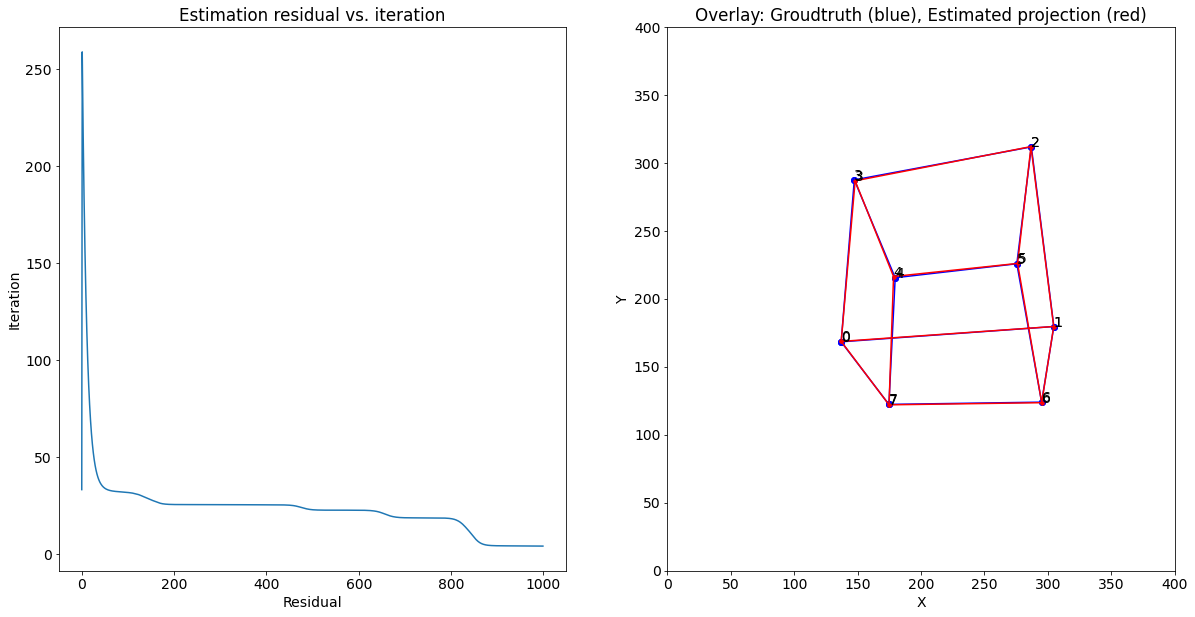

In [ ]:
from scipy.spatial.transform import Rotation 

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def calibrateCamera (image_x_pts, image_y_pts, world_pts_3D) :
    
    # initial estimate of the intrinsic, rotation, and translation parameters
    with torch.no_grad():
        # Initialize using  DLT
        
        error_, P_init = DLT_estimate (image_x_pts, image_y_pts, world_pts_3D)
        P_init = P_init.squeeze().reshape(3,4)
        K_init, R_init, t_int = estimate_KRt_from_P (P_init)
        print('Initial DLT estimate \nK=\n', K_init,  '\n R=\n', R_init, '\n t=\n', t_int)
        # using scipy rotation construct to simplify the translations between different representations
        r_init = Rotation.from_matrix(R_init)
        q = r_init.as_quat()
        '''
        # Hard coded initialization
        r_init = Rotation.from_euler('zyx', [0, 0, 0], degrees=True)
        q = r_init.as_quat()
        K_init = K_gt
        t_int = [0, 0, 40]
        '''
    
    '''14 parameters: (f/s_x, gamma, c_x, f/s_y, c_y,) (q_x, q_y, q_z, q_w) (t_x, t_y, t_z,) (kappa1, kappa2)
                         0,    1  ,   2 ,     3,   4 ,   5 ,  6  , 7,    8,   9,   10   11,     12,     13'''
    p_k    = torch.tensor([ K_init[0,0], K_init[0,1],  K_init[0, 2], K_init[1,1], K_init[1,2], q[0], q[1], q[2], q[3], t_int[0], t_int[1], t_int[2], 0, 0], device=device, dtype=torch.double, requires_grad=True)
     
    X_w_gt  = world_pts_3D.squeeze().clone().detach().requires_grad_(False) #torch.tensor(world_pts_3D.squeeze(), device = device, requires_grad=False) # homogenous coordinates
    x_im_gt = image_x_pts.squeeze().clone().detach().requires_grad_(False) #torch.tensor(image_x_pts.squeeze(), device = device, requires_grad=False) # non-homogenous coordinates
    y_im_gt = image_y_pts.squeeze().clone().detach().requires_grad_(False) #torch.tensor(image_y_pts.squeeze(), device = device, requires_grad=False) # non-homogenous coordinates

    X_w_gt = X_w_gt.to(device)
    x_im_gt = x_im_gt.to(device)
    y_im_gt = y_im_gt.to(device)

    # We will use a good optimizer in pytorch that is NOT just gradient descent.
    # This is a very memory intensive optimizer so cannot be used for large deep learning problems
    # It is basically the approach described in https://www.cs.ubc.ca/~schmidtm/Software/minFunc.html
    # It is implementation of the Matlab function for unconstrained optimization of differentiable 
    # real-valued multivariate functions using line-search methods
    #
    # It is a quasi Newton method
    optimizer = torch.optim.LBFGS([p_k], max_iter=1000, lr=.05)

    error_history = []
    def fit ():
        # Note X_world_gt, x_image_gt is not defined in this function scope
        optimizer.zero_grad()
        x_image, y_image = forward_projective (p_k, X_w_gt) # This function was defined early in this notebook
        residual = (torch.pow(x_image - x_im_gt, 2) + 
                    torch.pow(y_image - y_im_gt, 2)).sum()

        residual.backward()
        error_history.append(residual.clone().detach().item()) # store the loss history
        return residual

    print('\nRunning LBDGS optimizer')
    %time optimizer.step(fit) # %time is jupyter timing magic 

    print('\nFinal estimate:', p_k)
    print('Number of steps:', len(error_history))

    if p_k.is_cuda :
        p_k = p_k.to ('cpu')
    return(error_history, p_k.detach().numpy())

#-------------------------------------------------------------------------------
fit_error_trace, p_est = calibrateCamera (x_image_gt, y_image_gt, X_world_gt)

K_est = np.array([[p_est[0], p_est[1], p_est[2]], [0, p_est[3], p_est[4]],[0,0,1]])
R_est = Rotation.from_quat(p_est[5:9]/np.linalg.norm(p_est[5:9]))
t_est = np.array([p_est[9], p_est[10], p_est[11]])

#---------------------

print('\n\nEstimated K= \n', K_est)
print('K matrix (ground truth) =\n', K_gt)


print('\n\nEstimated R=\n', R_est.as_matrix())
print('Euler angles: ', R_est.as_euler('zyx', degrees=True))
print('R matrix (ground truth) =\n', RT_gt[0:3,0:3])


print('\n\nEstimated t= ', t_est)
print('t (ground truth) =', RT_gt[0:3, 3])


print('\nEstimated kappa_1 = {:0.3f}, kappa_2 = {:0.3f}'.format(p_est[12], p_est[13]))
print('True kappa_1 = {:0.3f}, kappa_2 = {:0.3f}'.format(kappa1, kappa2))


# plot the cube in the the world coordinates
fig = plt.figure(figsize=(20,10))
plt.rc('font', size=14)  

ax = fig.add_subplot(1,2,1)
#print(fit_error_trace)
ax.plot(fit_error_trace)
ax.set_title ('Estimation residual vs. iteration')
ax.set_xlabel ('Residual')
ax.set_ylabel ('Iteration')

ax = fig.add_subplot(1,2,2)
plot_cube_2D (ax, x_image_gt.numpy(), y_image_gt.numpy())
ax.set_title('Overlay: Groudtruth (blue), Estimated projection (red)')

x_image, y_image = forward_projective (torch.tensor(p_est), X_world_gt)
plot_cube_2D (ax, x_image.numpy(), y_image.numpy(), c='r', marker='.')

projected_error = torch.sum(torch.pow(x_image_gt - x_image, 2) + 
                            torch.pow(y_image_gt - y_image, 2))

print('\nProjected error on image: {:3.2f} pixels'.format(projected_error));


# Assignment -- Different Initializations

This exercise will experiment with how good an initialization you need for the nonlinear estimation to converge to near the optimal value. Instead of the DLT-based estimate, you will use random starting points around optimal value and note how far you can be from the optimal value at the beginning of the search and still converge.

Modify the code to initialize the search for optimal paramters to be with the following Euler rotation angles ('zyx') and translations:

1. rotation angles: $[0, 5, 25], ('zyx')$; translation $ [0, 0, 100]$.
2. rotation angles: $[0, 15, 35], ('zyx')$; translation $ [0, 0, 100]$.  
3. rotation angles: $[0, 0, 0], ('zyx')$; translation $ [0, 0, 600]$. 
4. rotation angles: $[0, 0, 0], ('zyx')$; translation $ [0, 0, 400]$. 
5. rotation angles: $[0, 0, 0], ('zyx')$; translation $ [0, 0, 100]$. 

For the initialization of the intrinsic parameter matrix $\mathbf{K}$, repeat the above for the two cases below:

* Use the ground truth intrinsic parameter matrix
* Use the DLT estimate of the intrinsic parameter matrix

Use a learning rate of 0.05 and 1000 iterations.


Compare the results for these 10 cases with full DLT initialized result and comment on your observations. To compare, use both the estimates of the transformations and also the projected error on the image. What tentative conclusions can you draw?



# Assignment -- Objects near and far

Is there a difference in calibrating with an object near and imaged with a smaller focal length versus far away and imaged with a longer focal length? Assume that the distances and focal lengths are chosen so that the projected object on the image is of similar size for both these cases.

Experiment with the code in this notebook and answer this question.



# Assignment - Pose Estimation

Let us say you are given a 3D geometric model of an object (say a human face) and an image of the same object (e.g. image of the face taken from an angle, non-frontal). You know (i) the intrinsic parameters of the camera and (ii) correpondences between the 2D image and the 3D model of some features on the face such as from the corners of the lips, nose, eyes etc. How can you estimate the 3D pose of the viewed face?

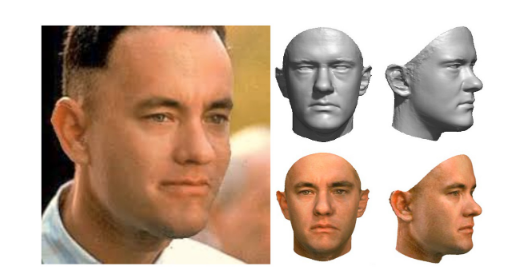

Taken from "3D Morphable Face Models—Past, Present, and Future", https://dl.acm.org/doi/pdf/10.1145/3395208